# Conductance of a Diatomic Molecule

This notebook uses the QuTiP package:

J. R. Johansson, P. D. Nation, and F. Nori: "QuTiP 2: A Python framework for the dynamics of open quantum systems.", Comp. Phys. Comm. 184, 1234 (2013) [DOI: 10.1016/j.cpc.2012.11.019].

J. R. Johansson, P. D. Nation, and F. Nori: "QuTiP: An open-source Python framework for the dynamics of open quantum systems.", Comp. Phys. Comm. 183, 1760–1772 (2012) [DOI: 10.1016/j.cpc.2012.02.021].

In [2]:
# Import necesary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qutip as Q
from scipy import constants,integrate

import time

# 1. Introduction of the problem

We have the following system: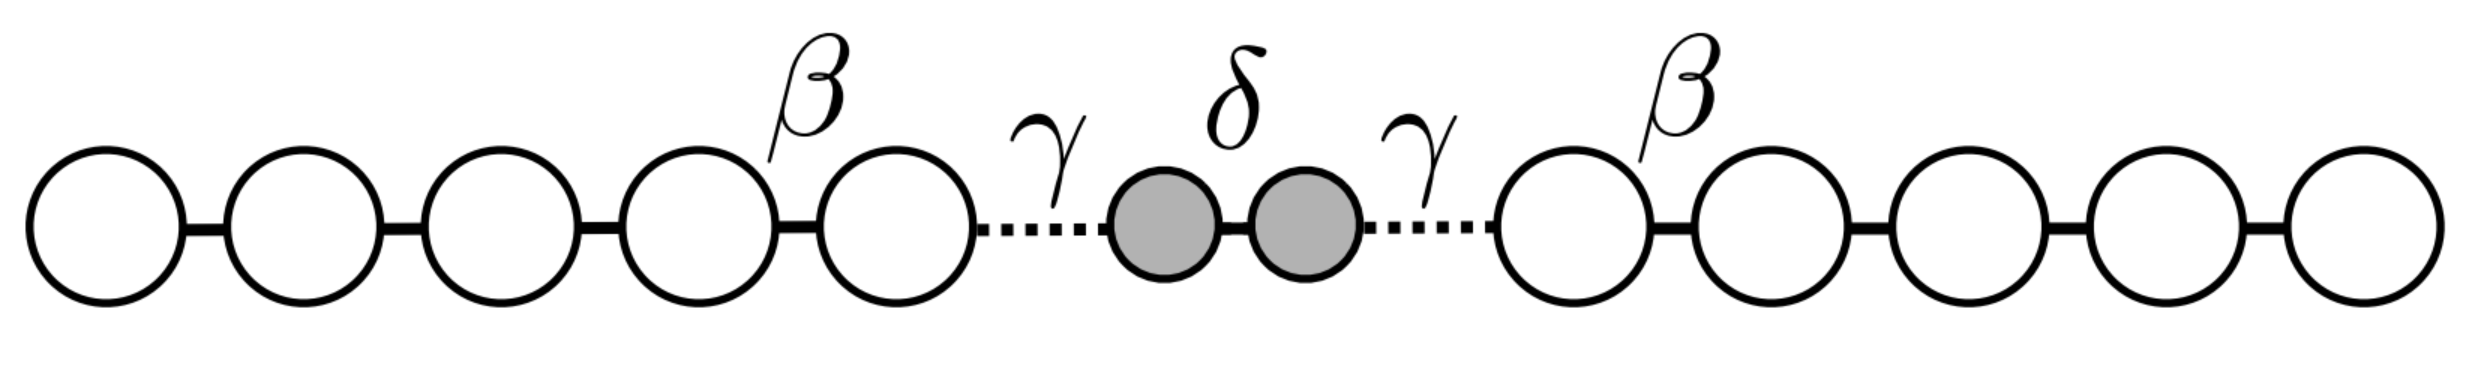

The system has $N$ orbitals in the left chain denoted by $|L_j\rangle,\ j \in \{1,\ldots,N\}$, $N$ orbitals in the right chain denoted by $|R_j\rangle,\ j \in \{1,\ldots,N\}$, and a diatomic molecule in between the chains with orbitals $|L_0\rangle$ and $|R_0\rangle$. The Hamiltonian is defined as:

$$ H = H^0 + V_{coupling} $$

where

$$ H^0 = H_L + H_R + H_C $$

$$ H_L = \varepsilon_L |L_1\rangle\langle L_1| + \sum_{j=2}^N \biggl[\varepsilon_L|L_j\rangle\langle L_j| + \beta\bigl(|L_j\rangle\langle L_{j-1}| + |L_{j-1}\rangle\langle L_j|\bigr)\biggr]$$

$$ H_R = \varepsilon_R |R_1\rangle\langle R_1| + \sum_{j=2}^N \biggl[\varepsilon_R|R_j\rangle\langle R_j| + \beta\bigl(|R_j\rangle\langle R_{j-1}| + |R_{j-1}\rangle\langle R_j|\bigr)\biggr]$$

$$ H_C = \varepsilon_{0,L} |L_0\rangle\langle L_0| + \varepsilon_{0,R} |R_0\rangle\langle R_0| + \delta \bigl(|L_0\rangle\langle R_0| + |R_0\rangle\langle L_0|\bigr) $$

and

$$ V_{coupling} = \gamma \bigl(|L_1\rangle\langle L_0|+|L_0\rangle\langle L_1| + |R_1\rangle\langle R_0| + |R_0\rangle\langle R_1|\bigr) $$


For this particular problem, we also know that the left and right chains are subjected to constant potentials $V/2$ and $-V/2$, respectively. This gives the following energies for the orbitals:

$$\varepsilon_L = \frac{e^+ V}{2}\ \ ; \ \ \varepsilon_R = \frac{-e^+ V}{2}$$


## 1.1. Orbital representation of the Hamiltonian

In an orbital representation of the Hamiltonian, i.e. using the ordered base $\{|L_{N}\rangle, \ldots, |L_1\rangle, |L_0\rangle, |R_0\rangle, |R_1\rangle, \ldots, |R_N\rangle\}$, we have:


$$ H\dot{=} \begin{bmatrix}
\ddots & \ddots &  & & & & & \\
\ddots & \varepsilon_L & \beta & & & & & \\
 & \beta & \varepsilon_L & \gamma & & & & \\
 & & \gamma & \varepsilon_{0,L} & \delta & & & \\
 & & & \delta & \varepsilon_{0,R} & \gamma & & \\
& & & & \gamma & \varepsilon_R & \beta &\\
& & & & & \beta & \varepsilon_R & \ddots\\
& & & & & & \ddots & \ddots\\
\end{bmatrix}$$


## 1.2. One-body density operator

Since we assume the electrons of the system to be non-interacting, we know that the one-body density matrix is given by:

$$ \rho^{(1)} = \sum_i |\psi_i\rangle f(\varepsilon_i - \mu)\langle\psi_i| $$

Where $|\psi_i\rangle$ is a given eigenstate with eigenvalue $\varepsilon_i$, $f(\varepsilon_i-\mu)$ is the Fermi distribution

$$f(\varepsilon_i - \mu) = \frac{1}{\exp\bigl[(\varepsilon_i-\mu)/k_B T\bigr] + 1} $$

and $\mu$ is the Fermi energy of the system. 

We know that the equation of motion for $\rho^{(1)}$ is given by:

$$ \dot{\rho}^{(1)}=\frac{d\rho^{(1)}}{dt} = \frac{-i}{\hbar}\bigl[H, \rho^{(1)}\bigr]$$

In this case, we use the following algorithm for the integration of $\rho^{(1)}$:

$$\rho^{(1)}(t+\Delta t) = \rho^{(1)}(t-\Delta t) + 2\Delta t\dot{\rho}^{(1)}(t) $$



## 1.3. Current and conductance

We know that the charge in this system is represented by $\rho^{(1)}$. By taking the definition of the current $I$ as the time derivative of the charge in a given place of a system, we can define the total current passing through site $j$ as:

$$\dot{\rho}^{(1)}_{jj} = \frac{-i}{\hbar}\bigl[H,\rho^{(1)}\bigr]_{jj} = 
\frac{-i}{\hbar}\sum_k H_{jk}\bigl(\rho^{(1)}_{kj}-\rho^{(1)}_{jk}\bigr) = 
\frac{2}{\hbar}\sum_k H_{jk}\Im\bigl(\rho^{(1)}_{kj}\bigr)$$

Specifically, we can see that the current that passes through the link between site $k$ and site $j$ is given by:

$$I_{jk} = \frac{2}{\hbar}H_{jk}\Im\bigl(\rho^{(1)}_{kj}\bigr) $$

From this, we define the conductance $G$ of the system as:

$$ G = \frac{I_{steady}}{V} $$

where $I_{steady}$ is the value of the current when it reaches a steady state.


## 1.4. Non-Equilibrium Green's function formalism (NEGF)

We start by re-stating the system's Hamiltonian as:

$$ [H] = \begin{bmatrix}\begin{array}{c|c|c}
  H_L & V_{LC} & 0\\
  \hline
  V_{CL} & H_C & V_{CR}\\
  \hline
  0 & V_{RC} & H_R
\end{array}\end{bmatrix}$$

Where $V_{LC}+V_{CL}+V_{CR}+V_{RC} = V_{coupling}$. We define the elements of the Green's function for the center molecule orbitals as:

$$G_C(z) = \bigl(z-H_C+\Sigma_L+\Sigma_R\bigr)^{-1}$$

Also, we define the following:

$$G_R^0(z) = \bigl(z-H_R\bigr)^{-1}\ \ , \ \ G_L^0(z) = \bigl(z-H_L\bigr)^{-1} $$

and

$$G_{R}^{0\ \pm}(E) = \lim_{\eta\rightarrow0^\pm}G_R^0(E+i\eta) \ \ , \ \ 
G_{L}^{0\ \pm}(E) = \lim_{\eta\rightarrow0^\pm}G_L^0(E+i\eta)$$


Now, the self-energies of the system are defined by:

$$\Sigma_L(z) = V_{CL}G_L^0(z)V_{LC} \ \ , \ \ \Sigma_R(z) = V_{CR}G_R^0(z)V_{RC} $$

We can see that the elements of the couplings are given by:

$$[V_{CL}]_{jk} = \delta_{j,N+1}\delta_{k,N}\gamma \ \ , \ \ [V_{LC}]_{jk} = \delta_{j,N}\delta_{k,N+1}\gamma$$

$$[V_{CR}]_{jk} = \delta_{j,N+2}\delta_{k,N+3}\gamma \ \ , \ \ [V_{RC}]_{jk} = \delta_{j,N+3}\delta_{k,N+2}\gamma$$

From this, it follows that:

$$[\Sigma_L]_{jk} = \sum_{j'\ k'}[V_{CL}]_{jj'}[G_L^0(z)]_{j'k'}[V_{LC}]_{k'k} = 
\sum_{j'\ k'}\delta_{j,N+1}\delta_{j',N}\gamma[G_L^0(z)]_{j'k'}\delta_{k',N}\delta_{k,N+1}\gamma = 
\delta_{j,N+1}\delta_{k,N+1}\gamma^2[G_L^0(z)]_{N N}$$

$$[\Sigma_R]_{jk} = \sum_{j'\ k'}[V_{CR}]_{jj'}[G_R^0(z)]_{j'k'}[V_{RC}]_{k'k} = 
\sum_{j'\ k'}\delta_{j,N+2}\delta_{j',N+3}\gamma[G_R^0(z)]_{j'k'}\delta_{k',N+3}\delta_{k,N+2}\gamma = 
\delta_{j,N+2}\delta_{k,N+2}\gamma^2 [G_R^0(z)]_{N+3 N+3}$$

We now define $\Sigma_L^\pm$ and $\Sigma_R^\pm$ as:

$$[\Sigma_L^\pm]_{jk} = \delta_{j,N+1}\delta_{k,N+1}\gamma^2[G_L^{0\ \pm}(z)]_{N N} \ \ , \ \ 
[\Sigma_R^\pm]_{jk} = \delta_{j,N+2}\delta_{k,N+2}\gamma^2 [G_R^{0\ \pm}(z)]_{N+3\ N+3}$$

Taking the limit $N\rightarrow\infty$, $[G_L^{0}(z)]_{N N}$ and $[G_R^{0}(z)]_{N+3\ N+3}$ are given by:

$$[G_L^{0}(z)]_{N N} = \frac{z - e^+V/2}{2\beta^2}\left[1-\sqrt{1-\left(\frac{2\beta}{z - e^+V/2}\right)^2}\right]$$

$$[G_R^{0}(z)]_{N N} = \frac{z + e^+V/2}{2\beta^2}\left[1-\sqrt{1-\left(\frac{2\beta}{z + e^+V/2}\right)^2}\right]$$


Another set of useful operators are $\Gamma_L(z)$ and $\Gamma_R(z)$, defined as:

$$\Gamma_L(z) = i\bigl(\Sigma_L^+ - \Sigma_L^-\bigr) \ \ , \ \ 
\Gamma_R(z) = i\bigl(\Sigma_R^+ - \Sigma_R^-\bigr)$$

Finally, the steady current for our system is defined as:

$$I = \frac{-e^+}{\pi\hbar}\int_{-e^+V/2}^{e^+V/2}\text{Tr}\bigl[G_C^+\Gamma_L G_C^-\Gamma_R\bigr]\ dE $$

where

$$G_C^\pm(E) = \lim_{\eta\rightarrow0^\pm} G_C(E+i\eta)$$

# 2. Building the code

In [6]:
# Define h_bar
h_bar = constants.value('reduced Planck constant in eV s')

# Function that builds the Hamiltonian with the
# parameters of the system
def build_H(e_L, e_R, e_0_L, e_0_R, beta, gamma, delta, N):
    '''
    Params:
        e_L, e_R : float or int
            Orbital eigenvalues for the left and right chains,
            respectively. Must be given en eV.
        e_0_L, e_0_R : float or int
            Orbital eigenvalues for the left and right orbitals
            of the central molecule, respectively. Must be given
            in eV.
        beta : float or int
            Beta parameter of the system, interatomic coupling
            for the left and right chains. Must be given in eV.
        gamma : float or int
            Gamma parameter of the system, coupling between each 
            chain and the central molecule. Must be given in eV.
        delta : float or int
            Delta parameter of the system, coupling between the
            orbitals of the molecule. Must be given in eV.
        N : int
            Number of atoms in each chain.
    Output:
        Returns the Hamiltonian of the system as a QuTip operator,
        in the orbital states representation.
    '''
    # Initialize the matrix
    H_shape = (2*(N+1), 2*(N+1))
    H_matrix = np.zeros(shape=H_shape)
    
    # The molecule matrix elements start at this index
    c_idx = N
    # Assign molecule elements
    H_matrix[c_idx,c_idx] += e_0_L
    H_matrix[c_idx + 1,c_idx + 1] += e_0_R
    H_matrix[c_idx + 1, c_idx] += delta
    H_matrix[c_idx, c_idx + 1] += delta
    
    # Assign chain-molecule couplings
    gamma_couplings = [[c_idx - 1, c_idx], [c_idx, c_idx-1],
                       [c_idx + 1, c_idx + 2], 
                       [c_idx + 2, c_idx + 1]]
    for c in gamma_couplings:
        H_matrix[c[0],c[1]] += gamma
    
    # Assign left and right chains elements
    for i in range(N):
        # Left chain
        H_matrix[i,i] += e_L
        # Right chain
        H_matrix[2*N+1-i,2*N+1-i] += e_R
        # Chain couplings
        if i == 0:
            H_matrix[i,i+1] += beta
            H_matrix[2*N+1-i,2*N-i] += beta
        elif i == N-1:
            H_matrix[i,i-1] += beta
            H_matrix[2*N+1-i,2*N+2-i] += beta
        else:
            H_matrix[i,i+1] += beta
            H_matrix[i,i-1] += beta
            H_matrix[2*N+1-i,2*N-i] += beta
            H_matrix[2*N+1-i,2*N+2-i] += beta
        
    return Q.Qobj(H_matrix)


# Now we'll define the Fermi function
def f(T,epsilon,mu=0):
    '''
    Params:
        T : float or int
            Temperature of the system in Kelvin.
            Must have a positive value.
        epsilon : float or int
            Epsilon parameter of the fermi function,
            some energy value associated to a state.
            Must be given in eV.
        mu : float or int (optional)
            Fermi energy of the system in eV. 
            Default is 0.
    Output:
        Returns the value of the Fermi function: 
        f(epsilon-mu) = 1 / (exp((epsilon - mu) / (k_B * T)) + 1)
    '''
    # Define Boltzmann's constant and beta parameter
    k_B = constants.value('Boltzmann constant in eV/K')
    beta = 1 / (k_B * T)
    exp_term = beta * (epsilon - mu)
    # Return Fermi function
    if exp_term < -1000:
        return 1
    elif exp_term > 1000:
        return 0
    else:
        return np.power(np.exp(beta * (epsilon - mu)) + 1,-1)


# We need to define the one-body density matrix.
# It can be useful to define it as a function of 
# the Hamiltonian.
def rho_one_body(H, distribution='fermi', mu=0, T=273):
    '''
    Params:
        H : QuTip Qobj
            Hamiltonian of the system, from which to obtain the
            eigenstates and eigenvalues.
        distribution : str (optional)
            Distribution to use for the density operator, the
            Fermi distribution is used by default.
        mu : float or int (optional)
            Fermi energy to use when applying the Fermi distribution
            to the operator. Must be given in the same energy units
            as the eigenvalues of H.
        T : float or int (optional)
            Temperature of the system, must be positive and given in 
            Kelvin. Default is 273 K.
    Output:
        Returns the density one-body operator of the system H as a 
        QuTip Qobj, using the specified distribution.    
    '''
    # First let's check that the distribution specified by the user
    # is available
    av_dist = ['fermi']
    if not distribution in av_dist:
        print('Error: the specified distribution is not supported,'+\
              ' falling back to default Fermi distribution.')
        distribution = 'fermi'
    
    # Get eigenvalues and eigenstates
    e_vals, e_states = H.eigenstates()
    
    # Build density operator
    rho = 0*H.copy()
    if distribution == 'fermi':
        for i in range(len(e_states)):
            state = e_states[i]
            epsilon = e_vals[i]
            # Add projector to rho, scaled by f(epsilon-mu)
            rho += 2*f(T,epsilon,mu=mu)*(state * state.dag())
    
    return rho


# Auxiliary function that calculates the mean value
# of a one-body operator
def one_body_mean(rho,op):
    '''
    Params:
        rho : QuTip Qobj
            One-body density operator that represents 
            the system.
        op : QuTip Qobj
            One-body operator for which we want to 
            obtain the expected value in the given system, 
            must be of the same shape as rho.
    Output:
        Returns the expectation value of op as:
            <op> = Tr(rho * op)
    '''
    return (rho * op).tr()

# Auxiliary function that calculates the time
# derivative of a one-body density operator
def rho_dot(rho,H):
    '''
    Params:
        rho : QuTip Qobj
            One-body density operator for which
            to obtain the time derivative.
        H : QuTip Qobj
            Hamiltonian of the system, must be
            of the same shape as rho.
    Output:
        Returns the time derivative of rho, called
        rho_dt, as:
            rho_dt = -(i/h_bar) * [H,rho]
    '''
    return -(1j/h_bar) * Q.commutator(H, rho)


# Let's build a pipeline that integrates the rho operator
def rho_pipeline(V, e_0_L, e_0_R, beta, gamma, delta, N,
                 delta_t, steps, output_steps, ops=[], output=['rho'],
                 distribution='fermi',mu=0,T=273,
                 verbose=1):
    '''
    Params:
        V : float or int
            Potential of the system. Orbital eigenvalues for the 
            left and right chains are assigned as V/2 and -V/2,
            respectively. Must be given in V.
        e_0_L, e_0_R : float or int
            Orbital eigenvalues for the left and right orbitals
            of the central molecule, respectively. Must be given
            in eV.
        beta : float or int
            Beta parameter of the system, interatomic coupling
            for the left and right chains. Must be given in eV.
        gamma : float or int
            Gamma parameter of the system, coupling between each 
            chain and the central molecule. Must be given in eV.
        delta : float or int
            Delta parameter of the system, coupling between the
            orbitals of the molecule. Must be given in eV.
        N : int
            Number of atoms in each chain.
        delta_t : int or float
            Time diferential for the integration of the density
            operator, must be given in seconds.
        steps : int 
            Amount of steps for the integration of the density 
            operator. The final time reached by the system is
            t_final = steps * delta_t.
        output_steps : int
            Amount of steps at which to dump output data.
        ops : list of QuTip Qobj operators (optional)
            List of one-boy operators for which mean values are 
            going to be calculated during the integration. 
            Default is an empty list.
        output : list of str or int (optional)
            List of output information. Some options that can be
            included are 'rho', which outputs the complete density
            operator, tuples of ints (i,j) that output the element
            rho(i,j) in the orbital state representation. The mean
            values of the operators in ops are always added to the
            output data, and don't need to be specified here.
            Another option is 'tr_rho', which returns the trace of
            the density operator. Adding 'energy' returns the mean
            value of H. The option 'current' returns the current that
            goes through the molecule. Default is ['rho'].
        distribution : str (optional)
            Distribution to use for the density operator, the
            Fermi distribution is used by default.
        mu : float or int (optional)
            Fermi energy to use when applying the Fermi distribution
            to the operator. Must be given in the same energy units
            as the eigenvalues of H.
        T : float or int (optional)
            Temperature of the system, must be positive and given in 
            Kelvin. Default is 273 K.
        verbose : int (optional)
            Whether to print elapsed time (1), status of the simulation 
            (2) or nothing (0). Default is 1.
    Output:
        Returns a dictionary with keys as specified in output, and 
        'op1', 'op2', ..., for each operator specified in ops, 
        containing the results of the time integration of the 
        density operator. The equation used to integrate rho is:
            rho(t+delta_t) = rho(t-delta_t) + 2*delta_t*rho_dt(t)
        Where rho_dt(t) is the time derivative of rho at time t.
    '''
    # Start clock
    wall_time_start = time.time()
    # Build initial Hamiltonian of the system
    H = build_H(V/2, -V/2, e_0_L, e_0_R, beta, gamma, delta, N)
    # Build initial density operator
    rho = rho_one_body(H, distribution=distribution, mu=mu, T=T)
    # Build new Hamiltonian of the system
    H = build_H(0, 0, e_0_L, e_0_R, beta, gamma, delta, N)
    # Initialize dictionary for the results
    output_dict = {'t' : [0]}
    for key in output:
        output_dict[key] = []
    if len(ops) > 0:
        for i in range(len(ops)):
            op_key = 'op' + str(i+1)
            output_dict[op_key] = [one_body_mean(rho,ops[i])]
            
    # Add first stats of rho
    for key in output:
        tup_condition = (type(key)==type((0,0))\
                         or type(key)==type([0,0]))
        if key == 'rho':
            output_dict['rho'].append(rho)
        elif key == 'tr_rho':
            output_dict['tr_rho'].append(rho.tr())
        elif key == 'energy':
            output_dict['energy'].append(one_body_mean(rho,H))
        elif key == 'current':
            output_dict['current'].append(0)
        elif len(key) == 2 and tup_condition:
            output_dict[key].append(rho[key[0],key[1]])
        else:
            print('Error: Key %s is not available.' % key)
            return
    if verbose == 1 or verbose == 2:
        init_message = 'Running for %d steps with delta_t of %s s' %(steps,
                                                                 delta_t)
        print('Starting simulation: '+init_message)
    
    # Integrate equation of motion of rho
    # Initialize rho_old as rho(t=0)
    rho_old = rho.copy()
    for i in range(steps):
        # -----------------

        # Get new rho using:
        #  rho(t+delta_t) = rho(t-delta_t) + 2*delta_t*rho_dt(t)
        # 1. First calculate rho_dt(t)
        rho_dt = rho_dot(rho,H)
        # 2. Now get rho(t+dt)
        rho_new = rho_old + 2*delta_t*rho_dt
        # 3. Update values
        rho_old = rho.copy()
        rho = rho_new.copy()
        
        # -----------------
        
        # Get data, every (output_steps) iterations
        if (i+1) % output_steps == 0:
            if verbose == 2:
                print('Step %d of %d...' %(i+1,steps))
            # Save time
            t = (i+1)*delta_t
            output_dict['t'].append(t)
            
            # Save operators mean values
            if len(ops) > 0:
                for j in range(len(ops)):
                    op_key = 'op' + str(j+1)
                    output_dict[op_key].append(one_body_mean(rho,ops[j]))
            
            # Save rho stats
            for key in output:
                if key == 'rho':
                    output_dict['rho'].append(rho)
                elif key == 'tr_rho':
                    output_dict['tr_rho'].append(rho.tr())
                elif key == 'energy':
                    output_dict['energy'].append(one_body_mean(rho,H))
                elif key == 'current':
                    current = (2/h_bar)*H[N,N+1]*np.imag(rho[N+1,N])
                    output_dict['current'].append(current)
                elif len(key) == 2:
                    output_dict[key].append(rho[key[0],key[1]])

    wall_time = time.time() - wall_time_start
    if verbose == 1 or verbose == 2:
        print('Simulation finished with total wall time of: %f s' % wall_time)
    return output_dict

# Function that plots the results of the pipeline
def plot_results(output_dict, op_labels=[], keys=[], fontsize=15,
                 figsize=(21,13),filepath=None,dpi=200):
    '''
    Params:
        output_dict : dictionary
            Dictionary containing the results of the rho_pipeline
            function.
        op_labels : list of str (optional)
            Labels to use for the 'op1','op2',..., keys of the 
            dictionary. Uses the original keys as labels when an
            empty list is passed (default).
        keys : list (optional)
            List of results to plot from output_dict, or empty to 
            plot all of them (default).
        fontsize : int (optional)
            Fontsize for the labels and the legends of the plots.
            Default is 15.
        figsize : tuple of ints (optional)
            Width and height for each figure in inches, default is 
            (13,8).
        filepath : str or None (optional)
            File path to save the plots, can include folder location
            and plot name. If None (default), then the plots are not 
            saved.
        dpi : int (optional)
            The resolution of the saved figure in dots-per-inch. 
            Default is 200.
            
    Output:
        Plots the results of the rho_pipeline function.
    '''
    L_WIDTH = 2 # Line width
    if filepath != None:
        filepath = filepath.replace('.png','') # Get path ready
        
    # Define universal time label and time values
    time_label = r'$t$ [s]'
    time = output_dict['t']
    
    # Get keys, if not given
    if len(keys) == 0:
        keys = list(output_dict.keys())
    
    # Start plotting
    for i in range(len(keys)):
        key = keys[i]
        if key == 't': # Skip time
            pass
        else:
            fig = plt.Figure(figsize=figsize)
            plt.yticks(fontsize=fontsize-1)
            plt.xticks(fontsize=fontsize-1)
            plt.xlabel(time_label,fontsize=fontsize)
            plt.ticklabel_format(axis='y',#useOffset=False,
                                style='sci')

            tup_condition = (type(key)==type((0,0))\
                        or type(key)==type([0,0]))
            # Check for density operator stats
            if key == 'tr_rho':
                plt.plot(time,output_dict['tr_rho'],linewidth=L_WIDTH)
                plt.ylabel(r'Tr($\rho$)',fontsize=fontsize)
            elif key == 'current':
                # Get into numpy array
                key_arr = np.array(output_dict[key])
                # Check for complex values
                c_sum = np.sum(np.imag(np.array(output_dict[key])))
                if not np.isclose(c_sum,0):
                    plt.plot(time,np.real(key_arr),linewidth=L_WIDTH,
                        label=r'$\Re I$'+str(key))
                    plt.plot(time,np.imag(key_arr),linewidth=L_WIDTH,
                        label=r'$\Im I$'+str(key))
                    plt.legend(fontsize=fontsize)
                else:
                    plt.plot(time,np.real(key_arr),linewidth=L_WIDTH)
                plt.ylabel(r'$I$ [1/s]',fontsize=fontsize)
            elif len(key) == 2 and tup_condition:
                # Get into numpy array
                key_arr = np.array(output_dict[key])
                # Check for complex values
                c_sum = np.sum(np.imag(np.array(output_dict[key])))
                if not np.isclose(c_sum,0):
                    plt.plot(time,np.real(key_arr),linewidth=L_WIDTH,
                        label=r'$\Re \rho_{%d,%d}$'%(key[0],key[1]))
                    plt.plot(time,np.imag(key_arr),linewidth=L_WIDTH,
                        label=r'$\Im \rho_{%d,%d}$'%(key[0],key[1]))
                else:
                    plt.plot(time,np.real(key_arr),linewidth=L_WIDTH,
                        label=r'$\rho$'+str(key))
                plt.legend(fontsize=fontsize)
                plt.ylabel('Amplitude',fontsize=fontsize)

            # Let's move on to the operators
            else:
                if len(op_labels) > 0:
                    y_label = op_labels[int(key.replace('op',''))-1]
                else:
                    y_label = key
                # Check for complex values
                c_sum = np.sum(np.imag(np.array(output_dict[key])))
                if not np.isclose(c_sum,0):
                    plt.plot(time,np.real(key_arr),linewidth=L_WIDTH,
                             label=r'$\Re$'+y_label)
                    plt.plot(time,np.imag(key_arr),linewidth=L_WIDTH,
                             label=r'$\Im$'+y_label)
                else:
                    plt.plot(time,np.real(output_dict[key]))
                plt.ylabel(y_label, fontsize=fontsize)
                
            plt.tight_layout()
            if filepath != None:
                if len(key) == 2 and tup_condition:
                    key_path = '_%d_%d' % (key[0],key[1])
                else:
                    key_path = key
                plt.savefig(filepath+key_path+'.png',dpi=dpi)
            plt.show();
            
# Define function to compare state densities
def compare_densities(output_dict, keys=[], fontsize=15,
                 figsize=(21,13),filepath=None,dpi=200):
    '''
    Params:
        output_dict : dictionary
            Dictionary containing the results of the rho_pipeline
            function.
        keys : list (optional)
            Names of the density elements to plot from output_dict, 
            or empty to plot all of them (default).
        fontsize : int (optional)
            Fontsize for the labels and the legends of the plots.
            Default is 15.
        figsize : tuple of ints (optional)
            Width and height for each figure in inches, default is 
            (13,8).
        filepath : str or None (optional)
            File path to save the plots, can include folder location
            and plot name. If None (default), then the plots are not 
            saved.
        dpi : int (optional)
            The resolution of the saved figure in dots-per-inch. 
            Default is 200.
    Output:
         Plots a comparison of all the selcted density operator
         elements.
    '''
    L_WIDTH = 2 # Line width
    # Define universal time label and time values
    time_label = r'$t$ [s]'
    time = output_dict['t']
    # Get keys, if not given
    if len(keys) == 0:
        keys = list(output_dict.keys())
        
    # Start plotting
    fig = plt.Figure(figsize=figsize)
    plt.yticks(fontsize=fontsize-1)
    plt.xticks(fontsize=fontsize-1)
    plt.xlabel(time_label,fontsize=fontsize)
    plt.ticklabel_format(axis='y',#useOffset=False,
                        style='sci')
    for i in range(len(keys)):
        key = keys[i]
        tup_condition = (type(key)==type((0,0))\
                    or type(key)==type([0,0]))

        if len(key) == 2 and tup_condition:
            # Get into numpy array
            key_arr = np.array(output_dict[key])
            # Check for complex values
            c_sum = np.sum(np.imag(np.array(output_dict[key])))
            if not np.isclose(c_sum,0):
                plt.plot(time,np.real(key_arr),linewidth=L_WIDTH,
                    label=r'$\Re \rho$'+str(key))
                plt.plot(time,np.imag(key_arr),linewidth=L_WIDTH,
                    label=r'$\Im \rho$'+str(key))
            else:
                plt.plot(time,np.real(key_arr),linewidth=L_WIDTH,
                    label=r'$\rho_{%d,%d}$'%(key[0],key[1]))
            plt.legend(fontsize=fontsize)
            plt.ylabel('Amplitude',fontsize=fontsize)

    plt.tight_layout()
    if filepath != None:
        plt.savefig(filepath,dpi=dpi)
    plt.show();
    
    
    
# -------------

# Landauer Formalism
# Define G0_L and G0_R as a general function
def G_0(z,beta,V,LR):
    '''
    Params:
        z : complex or numpy array of complex
            Independent variable of the G_LR functions.
        beta : float or int
            Beta parameter of the system, coupling of each pair
            of atoms in both chains.
        V : float or int
            Potential of the respective chain.
        LR : str
            Either 'L' for the left chain, or 'R' for the right
            chain.
    Output:
        Returns the value of the G_0 at the end of the selected chain
        that is conected to the central molecule.
    '''
    if LR == 'L':
        term = z - V/2
    elif LR == 'R':
        term = z + V/2
    else:
        print('Error: LR must be either "L" or "R".')
        return
    sqrt_term = np.sqrt(1 - np.power(2*beta/term,2))
    return (term/(2*(beta**2))) * (1 - sqrt_term)


# Define Sigma_L and Sigma_R as a general operator
def Sigma(z,gamma,beta,V,LR):
    '''
    Params:
        z : complex or numpy array of complex
            Independent variable of the G_LR functions.
        gamma : float or int
            Gamma parameter of the system, coupling between 
            each chain and the central molecule.
        beta : float or int
            Beta parameter of the system, coupling of each pair
            of atoms in both chains.
        V : float or int
            Potential of the respective chain.
        LR : str
            Either 'L' for the left chain, or 'R' for the right
            chain.
    Output:
        Returns the Sigma operator as a QuTip Qobj for the 
        selected chain.
    '''
    if LR == 'L':
        Sigma_matrix = np.array([[(gamma**2)*G_0(z,beta,V,LR),0],
                                 [0,0]])
        return Q.Qobj(Sigma_matrix)
    elif LR == 'R':
        Sigma_matrix = np.array([[0,0],
                                 [0,(gamma**2)*G_0(z,beta,V,LR)]])
        return Q.Qobj(Sigma_matrix)
    else:
        print('Error: LR must be either "L" or "R".')
        return
    
    
# Define Gamma_L and Gamma_R as a general operator
def Gamma(E,gamma,beta,V,LR,eta=0.000001):
    '''
    Params:
        E : float or numpy array of float
            Independent variable of the G_LR functions.
        gamma : float or int
            Gamma parameter of the system, coupling between 
            each chain and the central molecule.
        beta : float or int
            Beta parameter of the system, coupling of each pair
            of atoms in both chains.
        V : float or int
            Potential of the respective chain.
        LR : str
            Either 'L' for the left chain, or 'R' for the right
            chain.
        eta : float (optional)
            Value used to approach the limit of the Sigma 
            operators. Default is 0.000001.
    Output:
        Returns the Gamma operator as a QuTip Qobj for the 
        selected chain.
    '''
    if LR == 'L' or LR == 'R':
        z_plus, z_minus = E + 1j*np.abs(eta), E - 1j*np.abs(eta)
        Sigmas = Sigma(z_plus,gamma,beta,V,LR) -\
                 Sigma(z_minus,gamma,beta,V,LR)
        return 1j*(Sigmas)
    else:
        print('Error: LR must be either "L" or "R".')
        return
    
    
# Define G_C operator as a function of z
def G_C(z,e_0_L,e_0_R,delta,gamma,beta,V):
    '''
    Params:
        z : complex or numpy array of complex
            Independent variable of the G_LR functions.
        e_0_L, e_0_R : float or int
            Orbital eigenvalues for the left and right orbitals
            of the central molecule, respectively.
        delta : float or int
            Delta parameter of the system, coupling of the 
            orbitals in the central molecule.
        gamma : float or int
            Gamma parameter of the system, coupling between 
            each chain and the central molecule.
        beta : float or int
            Beta parameter of the system, coupling of each pair
            of atoms in both chains.
        V : float or int
            Potential of the respective chain.
    Output:
        Returns the G_C operator as a QuTip Qobj.
    '''
    # First we define H_C and z*I
    H_C = Q.Qobj(np.array([
        [e_0_L,delta],[delta,e_0_R]]))
    Z = Q.Qobj(np.array([
        [z,0],[0,z]]))
    # Now we define the inverse of G_C
    G_C_inv = Z - H_C + Sigma(z,gamma,beta,V,'L')+\
                        Sigma(z,gamma,beta,V,'R')
    
    return G_C_inv.inv()


# Define transmission function
def T(E,e_0_L,e_0_R,delta,gamma,beta,V,eta=0.000001):
    '''
    Params:
        E : float or numpy array of float
            Independent variable of the G_LR functions.
        e_0_L, e_0_R : float or int
            Orbital eigenvalues for the left and right orbitals
            of the central molecule, respectively.
        delta : float or int
            Delta parameter of the system, coupling of the 
            orbitals in the central molecule.
        gamma : float or int
            Gamma parameter of the system, coupling between 
            each chain and the central molecule.
        beta : float or int
            Beta parameter of the system, coupling of each pair
            of atoms in both chains.
        V : float or int
            Potential of the respective chain.
        eta : float (optional)
            Value used to approach the limit of the Sigma 
            operators. Default is 0.000001.
    Output:
        Returns the transmission function of the system for
        a given value of E.
    '''
    # Get G_C_plus and G_C_minus
    G_C_plus = G_C(E+1j*np.abs(eta),e_0_L,e_0_R,
                   delta,gamma,beta,V)
    G_C_minus = G_C(E-1j*np.abs(eta),e_0_L,e_0_R,
                    delta,gamma,beta,V)
    
    # Get Gamma_L and Gamma_R
    Gamma_L = Gamma(E,gamma,beta,V,LR='L',eta=eta)
    Gamma_R = Gamma(E,gamma,beta,V,LR='R',eta=eta)
    
    # Return transmission function
    return (G_C_plus*Gamma_L*G_C_minus*Gamma_R).tr()


# Define function that calculates the current based
# on the Landauer formalism
def I_Landauer(e_0_L,e_0_R,delta,gamma,beta,V,
               eta=0.000001,e_plus=1):
    '''
    Params:
        e_0_L, e_0_R : float or int
            Orbital eigenvalues for the left and right orbitals
            of the central molecule, respectively.
        delta : float or int
            Delta parameter of the system, coupling of the 
            orbitals in the central molecule.
        gamma : float or int
            Gamma parameter of the system, coupling between 
            each chain and the central molecule.
        beta : float or int
            Beta parameter of the system, coupling of each pair
            of atoms in both chains.
        V : float or int
            Potential of the respective chain.
        eta : float (optional)
            Value used to approach the limit of the Sigma 
            operators. Default is 0.000001.
        e_plus : float or int
            Value of the proton charge, according to
            a given unit of measurement. Default is 1
            (natural units).
    Output:
        Returns the value of the current calculated from
        the transmission function in the Landauer formalism.
    '''
    # Define pre-factor
    pre_f = -e_plus/(np.pi*h_bar)
    
    # Perform integration
    top_lim, bot_lim = e_plus*V/2, -e_plus*V/2
    integral = integrate.quad(func=T,a=bot_lim,b=top_lim,
                 args=(e_0_L,e_0_R,delta,gamma,beta,V))
    return pre_f * integral[0]
    
    


# --------------
    
    
# Auxiliary function to compare currents
def compare_currents(output_dicts,key=None,labels=[], fontsize=15,
                 figsize=(21,13),filepath=None,dpi=200,
                 y_label= r'$I$ [1/s]'):
    '''
    Params:
        output_dicts : list
            List of dictionaries resulting from runs of the
            rho_pipeline function. All of them must have a 
            'current' key.
        key : str or None (optional)
            Key to use when searching in the simulation result
            dictionaries. Falls back to 'current' when key is
            None (default).
        labels : list (optional)
            List of labels for each respective simulation, or
            empty to use generic labels (default).
        fontsize : int (optional)
            Fontsize for the labels and the legends of the plots.
            Default is 15.
        figsize : tuple of ints (optional)
            Width and height for each figure in inches, default is 
            (13,8).
        filepath : str or None (optional)
            File path to save the plots, can include folder location
            and plot name. If None (default), then the plots are not 
            saved.
        dpi : int (optional)
            The resolution of the saved figure in dots-per-inch. 
            Default is 200.
        y_label : str (optional)
            Label to use for the y-axis of the plot. r'$I$ [1/s]' is
            used by default.
    Output:
         Plots a comparison of the current results for different
         simulations, or any given 'key' if specified in key.
    '''
    L_WIDTH = 2 # Line width
    # Define universal time label
    time_label = r'$t$ [s]'
    
    # Start plotting
    fig = plt.Figure(figsize=figsize)
    plt.yticks(fontsize=fontsize-1)
    plt.xticks(fontsize=fontsize-1)
    plt.xlabel(time_label,fontsize=fontsize)
    plt.ticklabel_format(axis='y',#useOffset=False,
                        style='sci')
    
    if key == None:
        key = 'current'
    
    for i in range(len(output_dicts)):
        output_dict = output_dicts[i]
        time = output_dict['t']
        if len(labels) > 0:
            label = labels[i]
        else:
            label = 'Exp. ' + str(i+1)
        # Get into numpy array
        key_arr = np.array(output_dict[key])
        # Check for complex values
        c_sum = np.sum(np.imag(np.array(output_dict[key])))
        if not np.isclose(c_sum,0):
            plt.plot(time,np.real(key_arr),linewidth=L_WIDTH,
                label=r'$\Re$'+label)
            plt.plot(time,np.imag(key_arr),linewidth=L_WIDTH,
                label=r'$\Im$'+label)
        else:
            plt.plot(time,np.real(key_arr),linewidth=L_WIDTH,
                label=label)
    if not None in labels:
        plt.legend(fontsize=fontsize)
    plt.ylabel(y_label,fontsize=fontsize)

    plt.tight_layout()
    if filepath != None:
        plt.savefig(filepath,dpi=dpi)
    plt.show();

# -----------------
# CONDUCTANCE CODE

# Function that gets steady current values
def get_I(data,cut_left=None,cut_right=None,
          steps_left=None,steps_right=None):
    '''
    Params:
        data : list
            List containing the dictionaries with the results
            from the rho_pipeline function runs. All of them
            must have a 'current' key.
        cut_left : int or float (optional)
            Left bound of the time values to use, must be 
            in seconds. Default is None.
        cut_right : int or float (optional)
            Right bound of the time values to use, must be 
            in seconds. Default is None.
        steps_left : int (optional)
            Left bound given in steps of the simulation. Is 
            used instead of cut_left when given with steps_right.
            Default is None.
        steps_right : int (optional)
            Right bound given in steps of the simulation. Is 
            used instead of cut_right when given with steps_left.
            Default is None.
    Output:
        Returns a list with the steady state value for each
        result dictionary in data, calculated as the mean in
        the interval defined by cut_left and cut_right, or by
        steps_left and steps_right, if either pair of bounds 
        is given.
    '''
    # Init result list
    I_steady = []
    
    # Get values
    for i in range(len(data)):
        df = pd.DataFrame(data[i])
        if steps_left != None and steps_right != None:
            I_vals = np.real(df.iloc[steps_left:steps_right]['current'].copy())
        elif cut_left != None and cut_right != None:
            I_vals = np.real(df.loc[(df['t'] >= cut_left)\
                            & (df['t'] <= cut_right)]['current'].copy())
        else:
            I_vals = np.real(df['current'])
        I_steady.append(np.mean(I_vals))
        
    return I_steady
    
# Function to plot the conductance spectrum
def plot_conductance(I_list, V_list, fontsize=15,
                 figsize=(21,13),filepath=None,dpi=200,
                 y_label= r'$G$ [$($sV$)^{-1}$]',
                 x_label=r'$V$ [V]'):
    '''
    Params:
        I_list : list or numpy array
            List with the values of I_steady.
        V_list : list or numpy array
            List with the values of V.
        fontsize : int (optional)
            Fontsize for the labels and the legends of the plots.
            Default is 15.
        figsize : tuple of ints (optional)
            Width and height for each figure in inches, default is 
            (13,8).
        filepath : str or None (optional)
            File path to save the plots, can include folder location
            and plot name. If None (default), then the plots are not 
            saved.
        dpi : int (optional)
            The resolution of the saved figure in dots-per-inch. 
            Default is 200.
        y_label : str (optional)
            Label to use for the y-axis of the plot. r'$G$ [$($sV$)^{-1}$]' is
            used by default.
        x_label : str (optional)
            Label to use for the x-axis of the plot. r'$V$ [V]' is
            used by default.
    Output:
        Calculates and plots the conductance spectrum for the given
        values of I_steady and V.
    '''
    # Start plotting
    fig = plt.Figure(figsize=figsize)
    plt.yticks(fontsize=fontsize-1)
    plt.xticks(fontsize=fontsize-1)
    plt.xlabel(x_label,fontsize=fontsize)
    plt.ylabel(y_label,fontsize=fontsize)
    plt.ticklabel_format(axis='y',#useOffset=False,
                        style='sci')
    
    # Calculate G
    G_vals = []
    for i in range(len(I_list)):
        G_vals.append(I_list[i]/V_list[i])
    
    # Plot
    plt.plot(V_list,G_vals,linewidth=2)
    plt.tight_layout()
    if filepath != None:
        plt.savefig(filepath,dpi=dpi)
    plt.show();
    
    
# Function to plot the conductance spectrum
def compare_conductance(I_lists, V_lists, labels, fontsize=15,
                 figsize=(21,13),filepath=None,dpi=200,
                 y_label= r'$G$ [$($sV$)^{-1}$]',
                 x_label=r'$V$ [V]'):
    '''
    Params:
        I_lists : list or numpy array
            List with different sets of I_steady.
        V_lists : list or numpy array
            List with different sets of V.
        labels : list of str
            Labels for the different sets of values.
        fontsize : int (optional)
            Fontsize for the labels and the legends of the plots.
            Default is 15.
        figsize : tuple of ints (optional)
            Width and height for each figure in inches, default is 
            (13,8).
        filepath : str or None (optional)
            File path to save the plots, can include folder location
            and plot name. If None (default), then the plots are not 
            saved.
        dpi : int (optional)
            The resolution of the saved figure in dots-per-inch. 
            Default is 200.
        y_label : str (optional)
            Label to use for the y-axis of the plot. r'$G$ [$($sV$)^{-1}$]' is
            used by default.
        x_label : str (optional)
            Label to use for the x-axis of the plot. r'$V$ [V]' is
            used by default.
    Output:
        Calculates and plots the conductance spectrums for the given
        sets of values of I_steady and V.
    '''
    # Start plotting
    fig = plt.Figure(figsize=figsize)
    plt.yticks(fontsize=fontsize-1)
    plt.xticks(fontsize=fontsize-1)
    plt.xlabel(x_label,fontsize=fontsize)
    plt.ylabel(y_label,fontsize=fontsize)
    plt.ticklabel_format(axis='y',#useOffset=False,
                        style='sci')
    
    # For every set of values
    for k in range(len(I_lists)):
        I_list = I_lists[k]
        V_list = V_lists[k]
        # Calculate G
        G_vals = []
        for i in range(len(I_list)):
            G_vals.append(I_list[i]/V_list[i])

        # Plot
        plt.plot(V_list,G_vals,linewidth=2, label=labels[k])
    plt.legend(fontsize=fontsize)
    plt.tight_layout()
    if filepath != None:
        plt.savefig(filepath,dpi=dpi)
    plt.show();
    


# 3. Analysing the results

## 3.1. Chain of Au atoms

In this case we use the following parameters

$$ V = 1\ \text{V} \ ,\ \beta=\gamma=\delta=-3.88\ \text{eV} \ , \ 
\varepsilon_{0,L}=\varepsilon_{0,R}=0\ \text{eV} $$

Assuming a temperature of $T=273\ \text{K}$ and a Fermi energy of $\mu=0\ \text{eV}$. A time diferential of $\delta_t = 10^{-18}\ \text{s}$ was used for the integration, and $15000$ steps were performed.

In [25]:
V, E_0 = 1, 0
beta, gamma, delta = -3.88, -3.88, -3.88 #eV
N = 50
delta_t, steps = 1e-18, 15000
AuChain_N50 = rho_pipeline(V, E_0, E_0, beta, gamma, delta, N,
             delta_t=delta_t, steps=steps, output_steps=20,T=273,
             ops=[build_H(0,0,E_0,E_0,beta, gamma, delta, N)], 
             output=['tr_rho','current',(0,0),(N,N),(2*N+1,2*N+1)],verbose=1)

Starting simulation: Running for 15000 steps with delta_t of 1e-18 s
Simulation finished with total wall time of: 20.875703 s


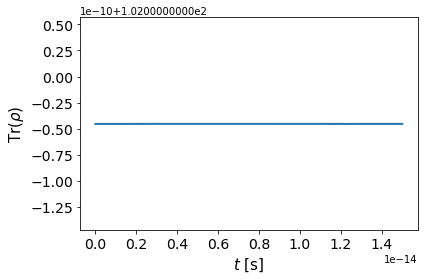

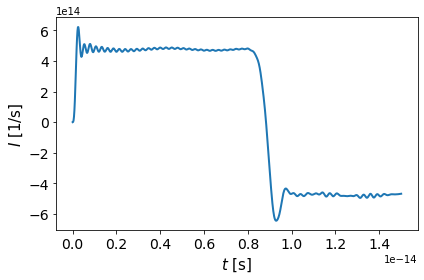

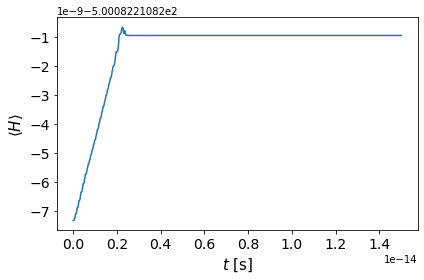

In [26]:
plot_results(AuChain_N50,op_labels=[r'$\langle H\rangle$'],
            keys=['tr_rho','current','op1'])

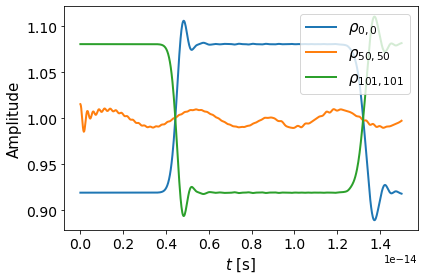

In [27]:
compare_densities(AuChain_N50)

## 3.2. Conductance spectrum of the chain of Au atoms

We use the following parameters

$$\beta=\gamma=\delta=-3.88\ \text{eV} \ , \ 
\varepsilon_{0,L}=\varepsilon_{0,R}=0\ \text{eV} $$

Assuming a temperature of $T=273\ \text{K}$ and a Fermi energy of $\mu=0\ \text{eV}$. A time diferential of $\delta_t = 10^{-18}\ \text{s}$ was used for the integration, and $7000$ steps were performed. Different values of the potential $V$ were used, so as to explore the conductance spectrum of the system.

In [32]:
E_0 = 0
beta, gamma, delta = -3.88, -3.88, -3.88 #eV
N = 50
delta_t, steps = 1e-18, 7000
V_list = [0.25*(i+1) for i in range(40)]

AuChain_N50_VResults = []
for V in V_list:
    print('Running simulation with V = %.3f' % V)
    AuChain_N50_V = rho_pipeline(V, E_0, E_0, beta, gamma, delta, N,
                 delta_t=delta_t, steps=steps, output_steps=20,
                 ops=[build_H(0,0,E_0,E_0,beta, gamma, delta, N)], 
                 output=['current'],verbose=0)
    AuChain_N50_VResults.append(AuChain_N50_V)

Running simulation with V = 0.250
Running simulation with V = 0.500
Running simulation with V = 0.750
Running simulation with V = 1.000
Running simulation with V = 1.250
Running simulation with V = 1.500
Running simulation with V = 1.750
Running simulation with V = 2.000
Running simulation with V = 2.250
Running simulation with V = 2.500
Running simulation with V = 2.750
Running simulation with V = 3.000
Running simulation with V = 3.250
Running simulation with V = 3.500
Running simulation with V = 3.750
Running simulation with V = 4.000
Running simulation with V = 4.250
Running simulation with V = 4.500
Running simulation with V = 4.750
Running simulation with V = 5.000
Running simulation with V = 5.250
Running simulation with V = 5.500
Running simulation with V = 5.750
Running simulation with V = 6.000
Running simulation with V = 6.250
Running simulation with V = 6.500
Running simulation with V = 6.750
Running simulation with V = 7.000
Running simulation with V = 7.250
Running simula

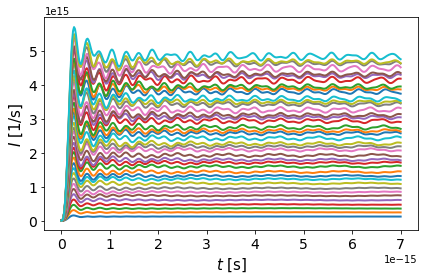

In [33]:
compare_currents(AuChain_N50_VResults,labels=[None for i in range(len(V_list))])

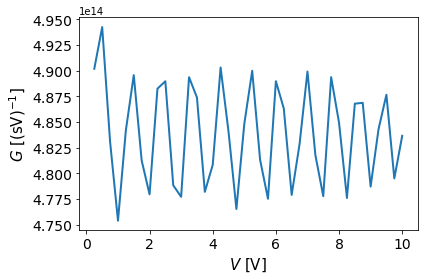

In [34]:
plot_conductance(get_I(AuChain_N50_VResults,cut_left=2e-15,cut_right=7e-15),
                 V_list)

In [35]:
E_0 = 0
beta, gamma, delta = -3.88, -3.88, -3.88 #eV
N = 50
delta_t, steps = 1e-18, 7000
V_list = [0.25*(i+1.0001) for i in range(39)]

AuChain_Landauer_VResults = []
for V in V_list:
    AuChain_Landauer_V = I_Landauer(E_0,E_0,delta,gamma,beta,-V)
    AuChain_Landauer_VResults.append(AuChain_Landauer_V)

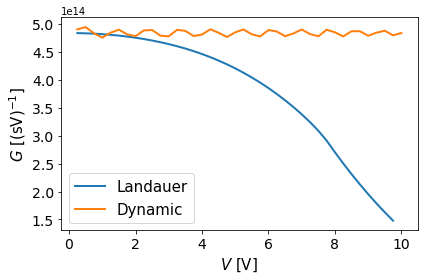

In [36]:
compare_conductance([AuChain_Landauer_VResults,
                     get_I(AuChain_N50_VResults,cut_left=2e-15,cut_right=7e-15)],
                 [[0.25*(i+1.0001) for i in range(39)],
                  [0.25*(i+1) for i in range(40)]],
                 labels=['Landauer','Dynamic'])

The difference between the simulation and the Landauer formalism is quite noticeable for this system. What happens if we increase the number of atoms?

In [28]:
E_0 = 0
beta, gamma, delta = -3.88, -3.88, -3.88 #eV
N = 100
delta_t, steps = 1e-18, 7000
V_list = [0.25*(i+1) for i in range(40)]

AuChain_N100_VResults = []
for V in V_list:
    print('Running simulation with V = %.3f' % V)
    AuChain_N100_V = rho_pipeline(V, E_0, E_0, beta, gamma, delta, N,
                 delta_t=delta_t, steps=steps, output_steps=20,
                 ops=[build_H(0,0,E_0,E_0,beta, gamma, delta, N)], 
                 output=['current'],verbose=0)
    AuChain_N100_VResults.append(AuChain_N100_V)

Running simulation with V = 0.250
Running simulation with V = 0.500
Running simulation with V = 0.750
Running simulation with V = 1.000
Running simulation with V = 1.250
Running simulation with V = 1.500
Running simulation with V = 1.750
Running simulation with V = 2.000
Running simulation with V = 2.250
Running simulation with V = 2.500
Running simulation with V = 2.750
Running simulation with V = 3.000
Running simulation with V = 3.250
Running simulation with V = 3.500
Running simulation with V = 3.750
Running simulation with V = 4.000
Running simulation with V = 4.250
Running simulation with V = 4.500
Running simulation with V = 4.750
Running simulation with V = 5.000
Running simulation with V = 5.250
Running simulation with V = 5.500
Running simulation with V = 5.750
Running simulation with V = 6.000
Running simulation with V = 6.250
Running simulation with V = 6.500
Running simulation with V = 6.750
Running simulation with V = 7.000
Running simulation with V = 7.250
Running simula

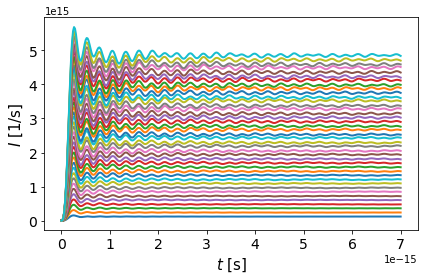

In [30]:
compare_currents(AuChain_N100_VResults,labels=[None for i in range(len(V_list))])

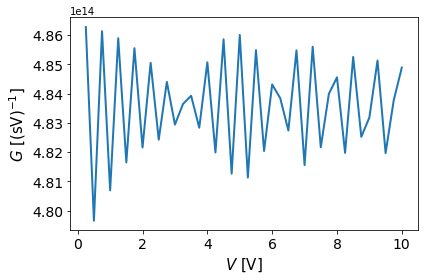

In [31]:
plot_conductance(get_I(AuChain_N100_VResults,cut_left=2e-15,cut_right=7e-15),
                 V_list)

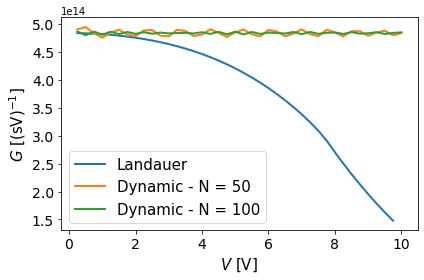

In [37]:
compare_conductance([AuChain_Landauer_VResults,
                     get_I(AuChain_N50_VResults,cut_left=2e-15,cut_right=7e-15),
                     get_I(AuChain_N100_VResults,cut_left=2e-15,cut_right=7e-15)],
                 [[0.25*(i+1.0001) for i in range(39)],
                  [0.25*(i+1) for i in range(40)],
                  [0.25*(i+1) for i in range(40)]],
                 labels=['Landauer','Dynamic - N = 50','Dynamic - N = 100'])

## 3.3. Chain of Au atoms with a defect

In this case we use the following parameters

$$ V = 1\ \text{V} \ ,\ \beta=\gamma=-3.88\ \text{eV} \ , \ \delta = -2.0\ \text{eV} \ , \
\varepsilon_{0,L}=\varepsilon_{0,R}=0\ \text{eV} $$

Assuming a temperature of $T=273\ \text{K}$ and a Fermi energy of $\mu=0\ \text{eV}$. A time diferential of $\delta_t = 10^{-18}\ \text{s}$ was used for the integration, and $15000$ steps were performed.

In [479]:
V, E_0 = 1, 0
beta, gamma, delta = -3.88, -3.88, -2.00 #eV
N = 100
delta_t, steps = 1e-18, 15000
AuChain_defect_N100 = rho_pipeline(V, E_0, E_0, beta, gamma, delta, N,
                     delta_t=delta_t, steps=steps, output_steps=20,
                     ops=[build_H(0,0,E_0,E_0,beta, gamma, delta, N)], 
                     output=['tr_rho','current',(0,0),(N,N),(2*N+1,2*N+1)],
                     verbose=1)

Starting simulation: Running for 15000 steps with delta_t of 1e-18 s
Simulation finished with total wall time of: 60.624614 s


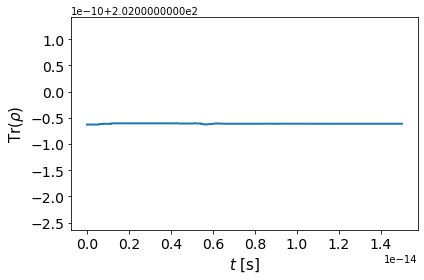

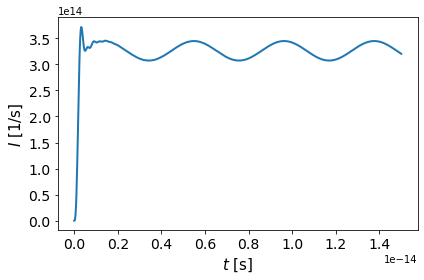

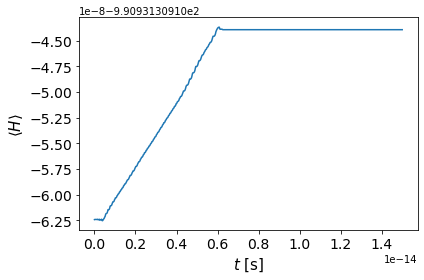

In [480]:
plot_results(AuChain_defect_N100,op_labels=[r'$\langle H\rangle$'],
            keys=['tr_rho','current','op1'])

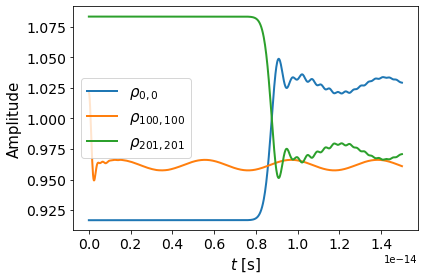

In [481]:
compare_densities(AuChain_defect_N100)

## 3.4. Conductance spectrum of the chain of Au atoms with a defect

We use the following parameters

$$\beta=\gamma=-3.88\ \text{eV} \ , \ \delta=-2.0\ \text{eV} \ , \
\varepsilon_{0,L}=\varepsilon_{0,R}=0\ \text{eV} $$

Assuming a temperature of $T=273\ \text{K}$ and a Fermi energy of $\mu=0\ \text{eV}$. A time diferential of $\delta_t = 10^{-18}\ \text{s}$ was used for the integration, and $8000$ steps were performed. Different values of the potential $V$ were used, so as to explore the conductance spectrum of the system.

In [482]:
E_0 = 0
beta, gamma, delta = -3.88, -3.88, -2.00 #eV
N = 100
delta_t, steps = 1e-18, 8000
V_list = [0.5*(i+1) for i in range(20)]

AuChain_defect_N100_VResults = []
for V in V_list:
    print('Running simulation with V = %.3f' % V)
    AuChain_defect_N100_V = rho_pipeline(V, E_0, E_0, beta, gamma, delta, N,
                 delta_t=delta_t, steps=steps, output_steps=20,
                 ops=[build_H(0,0,E_0,E_0,beta, gamma, delta, N)], 
                 output=['current'],verbose=0)
    AuChain_defect_N100_VResults.append(AuChain_defect_N100_V)

Running simulation with V = 0.500
Running simulation with V = 1.000
Running simulation with V = 1.500
Running simulation with V = 2.000
Running simulation with V = 2.500
Running simulation with V = 3.000
Running simulation with V = 3.500
Running simulation with V = 4.000
Running simulation with V = 4.500
Running simulation with V = 5.000
Running simulation with V = 5.500
Running simulation with V = 6.000
Running simulation with V = 6.500
Running simulation with V = 7.000
Running simulation with V = 7.500
Running simulation with V = 8.000
Running simulation with V = 8.500
Running simulation with V = 9.000
Running simulation with V = 9.500
Running simulation with V = 10.000


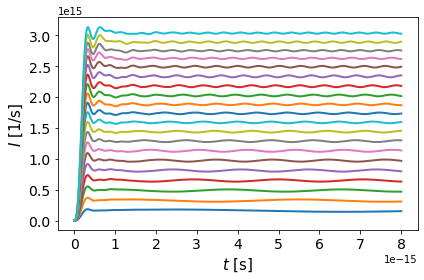

In [483]:
compare_currents(AuChain_defect_N100_VResults,labels=[None for i in range(len(V_list))])

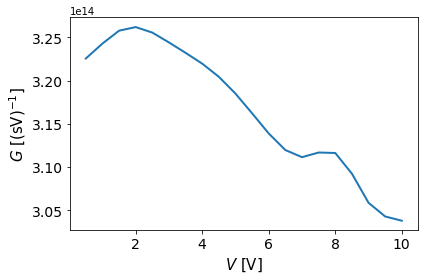

In [484]:
plot_conductance(get_I(AuChain_defect_N100_VResults,cut_left=2e-15,cut_right=7.5e-15),
                 V_list)

In [485]:
E_0 = 0
beta, gamma, delta = -3.88, -3.88, -2.00 #eV
V_list = [0.5*(i+1) for i in range(20)]
AuChain_defect_Landauer_VResults = []
for V in V_list:
    AuChain_defect_Landauer_V = I_Landauer(E_0,E_0,delta,gamma,beta,-V)
    AuChain_defect_Landauer_VResults.append(AuChain_defect_Landauer_V)

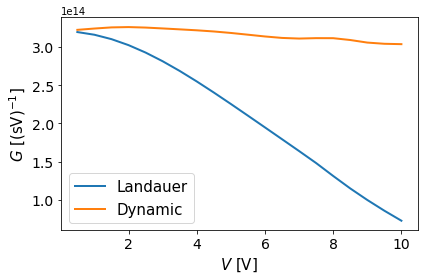

In [486]:
compare_conductance([AuChain_defect_Landauer_VResults,
                     get_I(AuChain_defect_N100_VResults,
                           cut_left=2e-15,cut_right=7.5e-15)],
                 [[0.5*(i+1) for i in range(20)],
                  [0.5*(i+1) for i in range(20)]],
                 labels=['Landauer','Dynamic'])

## 3.5. Chain of Au atoms with a molecule in the center

We use the following parameters

$$V=3\ \text{V}\ , \ \beta=-3.88\ \text{eV}\ , \ \gamma=-0.20\ \text{eV} \ , \ \delta=-0.50\ \text{eV} \ , \
\varepsilon_{0,L}=\varepsilon_{0,R}=0\ \text{eV} $$

Assuming a temperature of $T=273\ \text{K}$ and a Fermi energy of $\mu=0\ \text{eV}$. A time diferential of $\delta_t = 10^{-18}\ \text{s}$ was used for the integration, and $30000$ steps were performed.

In [487]:
V, E_0 = 3, 0
beta, gamma, delta = -3.88, -0.20, -0.50 #eV
N = 300
delta_t, steps = 1e-18, 30000
AuChain_molecule_N300 = rho_pipeline(V, E_0, E_0, beta, gamma, delta, N,
                     delta_t=delta_t, steps=steps, output_steps=40,
                     ops=[build_H(0,0,E_0,E_0,beta, gamma, delta, N)], 
                     output=['tr_rho','current',(0,0),(N,N),(2*N+1,2*N+1)],
                     verbose=1)

Starting simulation: Running for 30000 steps with delta_t of 1e-18 s
Simulation finished with total wall time of: 1045.383796 s


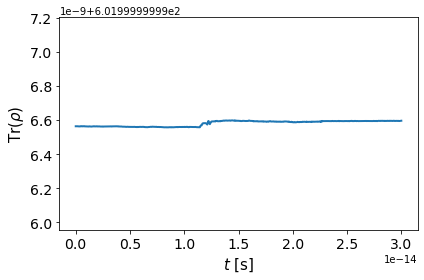

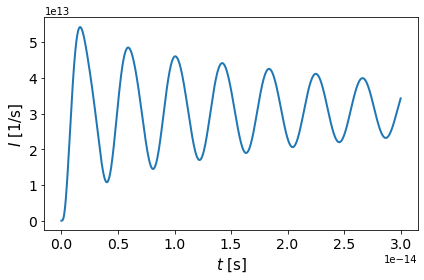

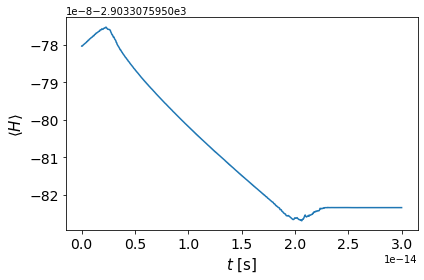

In [488]:
plot_results(AuChain_molecule_N300,op_labels=[r'$\langle H\rangle$'],
            keys=['tr_rho','current','op1'])

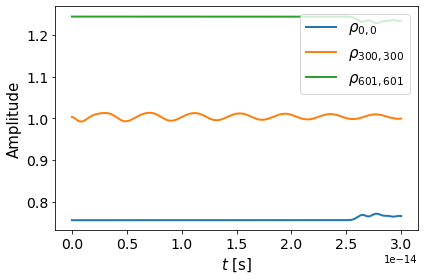

In [489]:
compare_densities(AuChain_molecule_N300)

## 3.6. Conductance spectrum of the chain of Au atoms with a molecule in the center

We use the following parameters

$$\beta=-3.88\ \text{eV}\ , \ \gamma=-0.20\ \text{eV} \ , \ \delta=-0.50\ \text{eV} \ , \
\varepsilon_{0,L}=\varepsilon_{0,R}=0\ \text{eV} $$

Assuming a temperature of $T=273\ \text{K}$ and a Fermi energy of $\mu=0\ \text{eV}$. A time diferential of $\delta_t = 10^{-18}\ \text{s}$ was used for the integration, and $15000$ steps were performed.  Different values of the potential $V$ were used, so as to explore the conductance spectrum of the system.

In [490]:
E_0 = 0
beta, gamma, delta = -3.88, -0.20, -0.50 #eV
N = 300
delta_t, steps = 1e-18, 15000
V_list = [0.25*(i+1) for i in range(12)]

AuChain_molecule_N300_VResults = []
for V in V_list:
    print('Running simulation with V = %.3f' % V)
    AuChain_molecule_N300_V = rho_pipeline(V, E_0, E_0, beta, gamma, delta, N,
                 delta_t=delta_t, steps=steps, output_steps=20,
                 ops=[build_H(0,0,E_0,E_0,beta, gamma, delta, N)], 
                 output=['tr_rho','current',(0,0),(N,N),(2*N+1,2*N+1)],verbose=0)
    AuChain_molecule_N300_VResults.append(AuChain_molecule_N300_V)

Running simulation with V = 0.250
Running simulation with V = 0.500
Running simulation with V = 0.750
Running simulation with V = 1.000
Running simulation with V = 1.250
Running simulation with V = 1.500
Running simulation with V = 1.750
Running simulation with V = 2.000
Running simulation with V = 2.250
Running simulation with V = 2.500
Running simulation with V = 2.750
Running simulation with V = 3.000


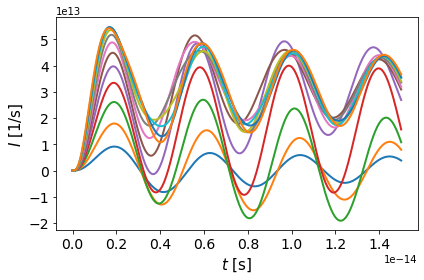

In [491]:
compare_currents(AuChain_molecule_N300_VResults,labels=[None for i in range(len(V_list))])

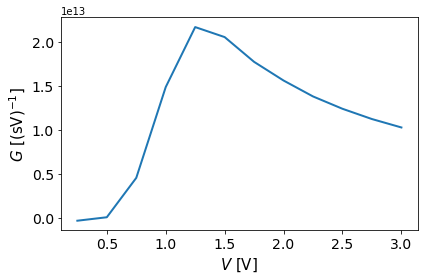

In [492]:
plot_conductance(get_I(AuChain_molecule_N300_VResults,cut_left=2e-15,cut_right=14.0e-15),
                 V_list)

In [493]:
E_0 = 0
beta, gamma, delta = -3.88, -0.20, -0.50 #eV
V_list = [0.125*(i+1) for i in range(40)]
AuChain_molecule_Landauer_VResults = []
for V in V_list:
    AuChain_molecule_Landauer_V = I_Landauer(E_0,E_0,delta,gamma,beta,-V)
    AuChain_molecule_Landauer_VResults.append(AuChain_molecule_Landauer_V)

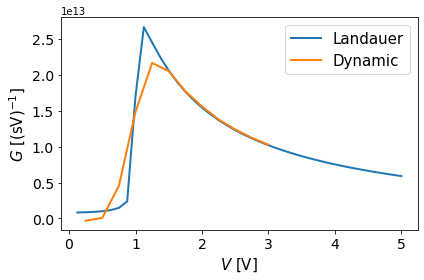

In [494]:
compare_conductance([AuChain_molecule_Landauer_VResults,
                     get_I(AuChain_molecule_N300_VResults,
                           cut_left=2e-15,cut_right=14.0e-15)],
                 [[0.125*(i+1) for i in range(40)],
                  [0.25*(i+1) for i in range(12)]],
                 labels=['Landauer','Dynamic'])

Not so bad...